In [229]:
import torch
from tqdm import tqdm
import kaolin
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
import utils.gradientUtils as gu
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.animation import PillowWriter
from io import BytesIO
from PIL import Image
from itertools import product
import pandas as pd


#cuda devices
device = torch.device("cuda:0")
print("Using device: ", torch.cuda.get_device_name(device))

#default tensor types
torch.set_default_tensor_type(torch.cuda.DoubleTensor)

multires = 2
lr_sites = 0.03
lr_model = 0.0003
iterations = 5000
save_every = 100
max_iter = 100
#learning_rate = 0.03
destination = "./images/autograd/multiple_sites/"


Using device:  NVIDIA GeForce RTX 3090


In [230]:
# MLP + Positional Encoding
class Decoder(torch.nn.Module):
    def __init__(self, input_dims = 3, internal_dims = 128, output_dims = 1, hidden = 5, multires = 2):
        super().__init__()
        self.embed_fn = None
        if multires > 0:
            embed_fn, input_ch = get_embedder(multires)
            self.embed_fn = embed_fn
            input_dims = input_ch

        net = (torch.nn.Linear(input_dims, internal_dims, bias=False), torch.nn.ReLU())
        for i in range(hidden-1):
            net = net + (torch.nn.Linear(internal_dims, internal_dims, bias=False), torch.nn.ReLU())
        net = net + (torch.nn.Linear(internal_dims, output_dims, bias=False),)
        self.net = torch.nn.Sequential(*net)

    def forward(self, p):
        if self.embed_fn is not None:
            p = self.embed_fn(p)
        out = self.net(p)
        return out

    def pre_train_sphere(self, iter):
        print ("Initialize SDF to sphere")
        loss_fn = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(list(self.parameters()), lr=1e-4)

        for i in tqdm(range(iter)):
            p = torch.rand((1024,3), device='cuda') - 0.5
            ref_value  = torch.sqrt((p**2).sum(-1)) - 0.3
            output = self(p) # sdf 0 , deform 1-3
            loss = loss_fn(output[...,0], ref_value)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Pre-trained MLP", loss.item())

    def pre_train_circle(self, iter):
        print("Initialize SDF to circle")
        loss_fn = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(list(self.parameters()), lr=1e-4)

        for i in tqdm(range(iter)):
            # Generate random points in the 2D plane (x, y)
            p = torch.rand((128*128, 2), device='cuda', requires_grad=True) - 0.5  # x and y values in the range [-0.5, 0.5]
            p = p*20
            # Calculate the reference value (SDF for circle)
            ref_value = torch.sqrt((p**2).sum(-1)) - 2.0  # Distance from origin (0, 0) minus the circle radius (2)

            # Get the network output
            output = self(p)
            
            # Compute the loss
            sdf_loss = loss_fn(output[..., 0], ref_value)
            
            
            
            # Compute gradients for Eikonal loss
            grads = torch.autograd.grad(
                outputs=output[..., 0],  # Network output
                inputs=p,                # Input coordinates
                grad_outputs=torch.ones_like(output[..., 0]),  # Gradient w.r.t. output
                create_graph=True,
                retain_graph=True
            )[0]

            # Eikonal loss: Enforce gradient norm to be 1
            eikonal_loss = ((grads.norm(2, dim=1) - 1) ** 2).mean()
            

            # Total loss: Combine SDF and Eikonal losses
            total_loss = sdf_loss #+ 1.0 * eikonal_loss  # Adjust the weight (0.1) as necessary

            # Perform backpropagation
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

        print("Pre-trained MLP", total_loss.item())


# Positional Encoding from https://github.com/yenchenlin/nerf-pytorch/blob/1f064835d2cca26e4df2d7d130daa39a8cee1795/run_nerf_helpers.py
class Embedder:
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        self.create_embedding_fn()
        
    def create_embedding_fn(self):
        embed_fns = []
        d = self.kwargs['input_dims']
        out_dim = 0
        if self.kwargs['include_input']:
            embed_fns.append(lambda x : x)
            out_dim += d
            
        max_freq = self.kwargs['max_freq_log2']
        N_freqs = self.kwargs['num_freqs']
        
        if self.kwargs['log_sampling']:
            freq_bands = 2.**torch.linspace(0., max_freq, steps=N_freqs)
        else:
            freq_bands = torch.linspace(2.**0., 2.**max_freq, steps=N_freqs)
            
        for freq in freq_bands:
            for p_fn in self.kwargs['periodic_fns']:
                embed_fns.append(lambda x, p_fn=p_fn, freq=freq : p_fn(x * freq))
                out_dim += d
                    
        self.embed_fns = embed_fns
        self.out_dim = out_dim
        
    def embed(self, inputs):
        return torch.cat([fn(inputs) for fn in self.embed_fns], -1)

def get_embedder(multires):
    embed_kwargs = {
                'include_input' : True,
                #'input_dims' : 3,
                'input_dims' : 2,
                'max_freq_log2' : multires-1,
                'num_freqs' : multires,
                'log_sampling' : True,
                'periodic_fns' : [torch.sin, torch.cos],
    }
    
    embedder_obj = Embedder(**embed_kwargs)
    embed = lambda x, eo=embedder_obj : eo.embed(x)
    return embed, embedder_obj.out_dim


In [231]:
# Python code for creating a CVT
# Vassilis Vassiliades - Inria, Nancy - April 2018

import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.cluster import KMeans
import argparse

# Default values
num_centroids = 128
dimensionality = 2
num_samples = 100000
num_replicates = 1
max_iterations = 100000
tolerance = 0.00001
verbose = True

X = np.random.rand(num_samples,dimensionality)

kmeans = KMeans(
    init='k-means++', 
    n_clusters=num_centroids, 
    n_init=num_replicates, 
    #n_jobs=-1, 
    max_iter=max_iterations, 
    tol=tolerance,
    verbose=0)

kmeans.fit(X)
centroids = kmeans.cluster_centers_

centroids = (np.array(centroids- 0.5))* 10.0
#make centroids double
centroids = centroids.astype(np.double)

#sites = torch.from_numpy(centroids).to(device).requires_grad_(True)

sites = torch.from_numpy(centroids).to(device, dtype=torch.double).requires_grad_(True)
print(sites.shape, sites.dtype)

torch.Size([128, 2]) torch.float64


In [232]:
def plot_sdf(ax, model):
    # Generate a grid of points
    grid_size = 100
    x = np.linspace(-10.0, 10.0, grid_size)
    y = np.linspace(-10.0, 10.0, grid_size)
    xx, yy = np.meshgrid(x, y)
    grid_points = np.stack([xx.ravel(), yy.ravel()], axis=1)
    
    # Convert grid points to a PyTorch tensor
    grid_points_tensor = torch.tensor(grid_points, device=device, dtype=torch.double)
    
    # Compute the SDF values
    sdf_values = model(grid_points_tensor)[:,0]
    sdf_values = sdf_values.reshape(grid_size, grid_size)
    #print(sdf_values)
    # Plot the SDF contour
    ax.contour(xx, yy, sdf_values.cpu().detach().numpy(), levels=[0] ,colors='black')
    return xx, yy, sdf_values
    
def compute_edge_smoothing_loss(edges, sites, model):
    """
    Computes the loss to smooth edges by minimizing the dot product between the 
    edge orientation and the gradient of the SDF at the midpoint of the edge, without a loop.
    
    Args:
        edges: Tensor of edges, each defined as [v1_idx, v2_idx, site1_idx, site2_idx].
        sites: Tensor of site positions.
        model
    
    Returns:
        smoothing_loss: The computed edge smoothing loss.
    """
    # Extract indices for vertices and sites
    v1_idx, v2_idx, site1_idx, site2_idx = edges[:, 0], edges[:, 1], edges[:, 2], edges[:, 3]
    
    # Extract positions of site1 and site2
    site1 = sites[site1_idx]  # Shape: (M, D)
    site2 = sites[site2_idx]  # Shape: (M, D)
    
    # Compute site direction and edge orientation
    site_direction = site2 - site1  # Shape: (M, D)
    site_direction = site_direction / torch.norm(site_direction, dim=1, keepdim=True)  # Normalize
    
    # Perpendicular orientation (2D case)
    edge_orientation = torch.stack([-site_direction[:, 1], site_direction[:, 0]], dim=1)  # Shape: (M, 2)
    
    # Compute midpoints of edges
    midpoints = (site1 + site2) / 2.0  # Shape: (M, D)
    midpoints.requires_grad_(True)  # Enable gradient tracking for midpoints
    
    # Compute SDF values at midpoints
    sdf_values = model(midpoints)[:,0]
    
    # Compute SDF gradients at midpoints
    torch.autograd.set_detect_anomaly(True)
    gradients_sdf = torch.autograd.grad(sdf_values, midpoints, grad_outputs=torch.ones_like(sdf_values), create_graph=True)[0]  # Shape: (M, D)
    
    # Dot product between edge orientation and SDF gradient
    dot_products = torch.sum(edge_orientation * gradients_sdf, dim=1)  # Shape: (M,)
    
    # Compute smoothing loss
    smoothing_loss = torch.mean(dot_products**2)  # Scalar

    return smoothing_loss

# def compute_cvt_loss(sites):
#     # Compute the Voronoi diagram based on the current site locations
#     vor = Voronoi(sites.detach().cpu().numpy())
    
#     centroids = []
#     for i in range(len(sites)):
#         # Find the region corresponding to the current site
#         region_index = vor.point_region[i]
#         region = vor.regions[region_index]
        
#         # Check if the region is valid (i.e., finite and non-empty)
#         if -1 not in region and len(region) > 0:
#             # Compute the centroid as the mean of the vertices in this region
#             vertices = vor.vertices[region]
#             centroid = vertices.mean(axis=0)
#         else:
#             # For regions that are unbounded, return the site itself as the centroid
#             centroid = sites[i].detach().cpu().numpy()
        
#         centroids.append(centroid)
    
#     centroids = torch.tensor(centroids, device=sites.device)
    
#     # Calculate the CVT loss using Mean Squared Error
#     cvt_loss = torch.mean(torch.norm(sites - centroids, p=2, dim=1) ** 2)
#     #cvt_loss = torch.mean(torch.sum(torch.norm(sites - centroids, p=2, dim=1) ** 2))
    
#     return cvt_loss

def compute_cvt_loss(sites):

    # Convert sites to NumPy for Voronoi computation
    sites_np = sites.detach().cpu().numpy()
    vor = Voronoi(sites_np)

    centroids = []
    valid_indices = []

    for i in range(len(sites_np)):
        region_index = vor.point_region[i]
        region = vor.regions[region_index]

        # Ensure the region is valid (finite and non-empty)
        if region and -1 not in region:
            vertices = vor.vertices[region]
            centroid = vertices.mean(axis=0)  # Compute centroid
            centroids.append(centroid)
            valid_indices.append(i)  # Store indices of valid centroids

    if len(centroids) == 0:
        return torch.tensor(0.0, device=sites.device)  # Return zero loss if no valid centroids

    # Convert centroids to a PyTorch tensor
    centroids = torch.tensor(np.array(centroids), device=sites.device, dtype=sites.dtype)

    # Select only valid sites for loss computation
    valid_sites = sites[valid_indices]

    # Compute Mean Squared Error (MSE) loss
    cvt_loss = torch.mean(torch.norm(valid_sites - centroids, p=2, dim=1) ** 2)

    return cvt_loss


# def min_distance_regularization_for_op_sites(edges, sites):
    
#     # Extract unique sites indices from edges 
#     # edges has 4 columns, 0,1 vertex, 2,3 sites
#     unique_indices = torch.unique(edges[:,2:4].flatten())
    
#     # Select sites corresponding to unique indices
#     sites_optimized = torch.stack([sites[i] for i in unique_indices])
    
#     # Compute pairwise distances between all sites
#     distances = torch.cdist(sites_optimized, sites_optimized, p=2)
    
#     # Create a mask to ignore distances between a site and itself
#     mask = torch.eye(distances.size(0), device=distances.device).bool()
#     distances = distances.masked_fill(mask, float("inf"))

#     # Calculate minimum distance for each site
#     min_distances = distances.min(dim=1).values  # Minimum distance to another site for each site

#     # Calculate the average of these minimum distances
#     avg_min_distance = min_distances.mean()

#     # Calculate penalties based on the condition provided
#     #penalties = torch.clamp(min_distances - avg_min_distance, min=0)

#     penalties = min_distances - avg_min_distance


#     # Sum the penalties to get the regularization loss
#     #regularization_loss = torch.mean(torch.sum(penalties**2))
#     regularization_loss = torch.mean(penalties**2)
    
#     return regularization_loss

def sdf_weighted_min_distance_loss(model, sites):
    """
    Computes a minimum distance regularization loss for sites, weighted by the absolute SDF values.

    Args:
        model: A neural network that predicts SDF values.
        sites (torch.Tensor): Tensor of shape (N, D), where N is the number of sites and D is the spatial dimension.

    Returns:
        torch.Tensor: The computed regularization loss.
    """
    # Get SDF predictions and take absolute values for weighting
    sdf_values = model(sites).squeeze()  # Assuming model outputs shape (N, 1) or (N,)
    sdf_weights = 1 / (1 + torch.abs(sdf_values)) # Inverse weighting (closer sites affect more)

    # Compute pairwise distances between all sites
    distances = torch.cdist(sites, sites, p=2)  # Shape: (N, N)

    # Mask diagonal to ignore self-distances
    mask = torch.eye(distances.size(0), device=distances.device, dtype=torch.bool)
    distances = distances.masked_fill(mask, float("inf"))

    # Find the minimum distance for each site to another site
    min_distances = distances.min(dim=1).values  # Shape: (N,)

    # Compute the average minimum distance
    avg_min_distance = min_distances.mean()

    # Compute penalties based on deviation from the average
    penalties = min_distances - avg_min_distance

    # Apply absolute SDF values as weighting factors
    weighted_penalties = sdf_weights * (penalties ** 2)

    # Compute final loss
    regularization_loss = weighted_penalties.mean()
    
    return regularization_loss




def chamfer_distance(true_point_cloud, vertices):
    # Compute pairwise distances
    # From point cloud to mesh edge points
    dist1 = torch.cdist(true_point_cloud, vertices).min(dim=1)[0]
    # From mesh edge points to point cloud
    dist2 = torch.cdist(vertices, true_point_cloud).min(dim=1)[0]
    # Chamfer distance is the sum (or average) of these distances
    chamfer_dist = torch.mean(dist1) + torch.mean(dist2)
    return chamfer_dist

def eikonal(model, p=[]):
    if len(p) == 0:
        # Generate random points in the 2D plane (x, y)
        p = torch.rand((128*128, 2), device=device, requires_grad=True) - 0.5
        p = p*20
    # Compute gradients for Eikonal loss
    grads = torch.autograd.grad(
        outputs=model(p)[:, 0],  # Network output
        inputs=p,                # Input coordinates
        grad_outputs=torch.ones_like(model(p)[:, 0]),  # Gradient w.r.t. output
        create_graph=True,
        retain_graph=True
    )[0]

    # Eikonal loss: Enforce gradient norm to be 1
    eikonal_loss = ((grads.norm(2, dim=1) - 1) ** 2).mean()

    return eikonal_loss
 
def domain_restriction(target_point_cloud, model, num_points=500, buffer_scale = 0.2):
    min_x, min_y = target_point_cloud[:,0].min(), target_point_cloud[:,1].min()
    max_x, max_y = target_point_cloud[:,0].max(), target_point_cloud[:,1].max()
    
    # Calculate the width and height of the bounding box
    bbox_width = max_x - min_x
    bbox_height = max_y - min_y

    # Define buffer zones based on the scale
    buffer_x = buffer_scale * bbox_width
    buffer_y = buffer_scale * bbox_height

    num_per_region = num_points // 4

    # Left of the bounding box
    left_x = torch.empty(num_per_region).uniform_(min_x - 2 * buffer_x, min_x)
    left_y = torch.empty(num_per_region).uniform_(min_y - buffer_y, max_y + buffer_y)

    # Right of the bounding box
    right_x = torch.empty(num_per_region).uniform_(max_x, max_x + 2 * buffer_x)
    right_y = torch.empty(num_per_region).uniform_(min_y - buffer_y, max_y + buffer_y)

    # Above the bounding box
    top_x = torch.empty(num_per_region).uniform_(min_x - buffer_x, max_x + buffer_x)
    top_y = torch.empty(num_per_region).uniform_(max_y, max_y + 2 * buffer_y)

    # Below the bounding box
    bottom_x = torch.empty(num_per_region).uniform_(min_x - buffer_x, max_x + buffer_x)
    bottom_y = torch.empty(num_per_region).uniform_(min_y - 2 * buffer_y, min_y)

    # Combine all points
    points_x = torch.cat([left_x, right_x, top_x, bottom_x])
    points_y = torch.cat([left_y, right_y, top_y, bottom_y])

    # Stack into (num_points, 2)
    points = torch.stack([points_x, points_y], dim=1)

    # Compute the SDF values and loss
    sdf_values = model(points)[:, 0]
    
    domain_loss = torch.relu(-sdf_values).mean()
    
    return domain_loss

In [233]:
def get_delaunay_neighbors_list(sites):
    # Detach and convert to NumPy for Delaunay triangulation
    points_np = sites.detach().cpu().numpy()
    
    # Compute the Delaunay triangulation
    tri = Delaunay(points_np)

    # Find the neighbors of each point
    neighbors = {i: set() for i in range(len(points_np))}
    for simplex in tri.simplices:
        # Each simplex is a triangle of three points; each point is a neighbor of the other two
        for i in range(3):
            for j in range(i + 1, 3):
                neighbors[simplex[i]].add(simplex[j])
                neighbors[simplex[j]].add(simplex[i])

    # Convert neighbor sets to lists for easier reading
    neighbors = {key: list(value) for key, value in neighbors.items()}
    return neighbors

def compute_vertices_index(neighbors):
    vertices_index_to_compute = []
    for site, adjacents in neighbors.items():
        for i in adjacents:
            for n in adjacents:
                if n != site and n != i and n in neighbors[i]:              
                    vertices_index_to_compute.append([i,site,n])
            
    # Set to store the canonical (sorted) version of each triplet
    seen_triplets = set()
    # Filtered list to store the unique triplets
    filtered_triplets = []
    # Process each triplet and keep only one permutation
    for triplet in vertices_index_to_compute:
        # Convert the triplet to a canonical form by sorting it
        canonical_triplet = tuple(sorted(triplet, key=str))
        # Check if this canonical triplet has been seen before
        if canonical_triplet not in seen_triplets:
            # If not seen, add it to the set and keep the triplet
            seen_triplets.add(canonical_triplet)
            filtered_triplets.append(triplet)

    return filtered_triplets

def compute_zero_crossing_vertices(sites, model):
    """
    Computes the indices of the sites composing vertices where neighboring sites have opposite or zero SDF values.

    Args:
        sites (torch.Tensor): (N, D) tensor of site positions.
        model (callable): Function or neural network that computes SDF values.

    Returns:
        zero_crossing_vertices_index (list of triplets): List of sites indices (si, sj, sk) where atleast 2 sites have opposing SDF signs.
    """
    # Compute Delaunay neighbors
    neighbors = get_delaunay_neighbors_list(sites)

    # Compute SDF values for all sites
    sdf_values = model(sites)  # Assuming model outputs (N, 1) or (N,) tensor

    # Find pairs of neighbors with opposing SDF values
    zero_crossing_pairs = set()
    for i, adjacents in neighbors.items():
        for j in adjacents:
            if i < j:  # Avoid duplicates
                sdf_i, sdf_j = sdf_values[i].item(), sdf_values[j].item()
                if sdf_i * sdf_j <= 0:  # Opposing signs or one is zero
                    zero_crossing_pairs.add((i, j))

    # Compute vertices (triplets) and filter only those involving zero-crossing pairs
    all_vertices = compute_vertices_index(neighbors)
    zero_crossing_vertices_index = []
    
    for triplet in all_vertices:
        triplet_pairs = {(triplet[0], triplet[1]), (triplet[1], triplet[2]), (triplet[0], triplet[2])}
        if any(pair in zero_crossing_pairs for pair in triplet_pairs):
            zero_crossing_vertices_index.append(triplet)

    return zero_crossing_vertices_index

def compute_vertex(s_i, s_j, s_k):
    # Unpack coordinates for each site
    x_i, y_i = s_i[0], s_i[1]
    x_j, y_j = s_j[0], s_j[1]
    x_k, y_k = s_k[0], s_k[1]
    
    # Calculate numerator and  for x coordinate
    n_x = (
        x_i**2 * (y_j - y_k)
        - x_j**2 * (y_i - y_k)
        + (x_k**2 + (y_i - y_k) * (y_j - y_k)) * (y_i - y_j)
    )

    # Calculate numerator for y coordinate
    n_y = -(
        x_i**2 * (x_j - x_k)
        - x_i * (x_j**2 - x_k**2 + y_j**2 - y_k**2)
        + x_j**2 * x_k
        - x_j * (x_k**2 - y_i**2 + y_k**2)
        - x_k * (y_i**2 - y_j**2)
    )
    
    # Calculate denominator 
    d = 2 * (x_i * (y_j - y_k) - x_j * (y_i - y_k) + x_k * (y_i - y_j))
    
    # Calculate x and y coordinates
    x = n_x / d
    y = n_y / d

    # Return x, y as a tensor to maintain the computational graph
    return torch.stack([x, y])

def compute_all_vertices(sites, vertices_to_compute):
    # Initialize an empty tensor for storing vertices
    vertices = []
    
    for triplet in vertices_to_compute:
        si = sites[triplet[0]]
        sj = sites[triplet[1]]
        sk = sites[triplet[2]]
        
        # Compute vertex for the triplet (si, sj, sk)
        v = compute_vertex(si, sj, sk)
        
        # Append to the list
        vertices.append(v)
    
    # Stack the list of vertices into a single tensor for easier gradient tracking
    vertices = torch.stack(vertices)
    return vertices

def upsampling_inside(sites, model):
    # Compute SDF values for each site
    sdf_values = model(sites)
    sdf_values = sdf_values.detach().cpu().numpy()
    
    sites_np = sites.detach().cpu().numpy()
    # Compute Voronoi diagram
    vor = Voronoi(sites_np)
    
    #edges = []
    negative_sites = np.array([]).reshape(0,2)

    for (point1, point2), (vertex1, vertex2) in zip(vor.ridge_points, vor.ridge_vertices):
        # Check if vertices are valid (not -1, which indicates infinity)
        if vertex1 == -1 or vertex2 == -1:
            continue
        
        # Check if the sites have different signs
        if np.sign(sdf_values[point1]) != np.sign(sdf_values[point2]):
            #edges.append((vertex1, vertex2))
            
            # Append the site with a negative SDF value
            # if sdf_values[point1] < 0 and not np.any([np.array_equal(sites_np[point1], site) for site in negative_sites]):
            #     negative_sites = np.concatenate((negative_sites, [sites_np[point1]]), axis=0)
            # if sdf_values[point2] < 0 and not np.any([np.array_equal(sites_np[point2], site) for site in negative_sites]):
            #     negative_sites = np.concatenate((negative_sites, [sites_np[point2]]), axis=0)
            
            # Append the site 
            #todo rename negative_sites
            if not np.any([np.array_equal(sites_np[point1], site) for site in negative_sites]):
                negative_sites = np.concatenate((negative_sites, [sites_np[point1]]), axis=0)
            if not np.any([np.array_equal(sites_np[point2], site) for site in negative_sites]):
                negative_sites = np.concatenate((negative_sites, [sites_np[point2]]), axis=0)
                
    new_sites = []
    
    for i, region_index in enumerate(vor.point_region):
        if sites_np[i] in negative_sites:
            current_site = sites[i]
            region = vor.regions[region_index]
            if -1 in region or len(region) == 0:  # Skip infinite or empty regions
                continue
        
            # Get vertices of the cell
            vertices = vor.vertices[region]
            vertices = torch.from_numpy(vor.vertices[region]).to(device)
            
            smallest_edge_length = float("inf")
            for j in range(len(vertices)):
                v1, v2 = vertices[j], vertices[(j + 1) % len(vertices)]
                # Compute edge length
                edge_length = torch.norm(v2 - v1)
                smallest_edge_length = min(smallest_edge_length, edge_length)

            # Calculate the distance from the barycenter to the vertices (circumradius)
            rad = smallest_edge_length / np.sqrt(3)  # For equilateral triangle, circumradius = edge / sqrt(3)

            # Define 3 angles for the triangle vertices, spaced 120 degrees apart
            angles = torch.tensor([0, 2 * np.pi / 3, 4 * np.pi / 3], device=device)
                
            # Calculate the offset vectors for each vertex around the barycenter
            offsets = torch.stack([torch.cos(angles), torch.sin(angles)], dim=1) * rad
                
            # Generate new sites by adding the offsets to the current site
            for offset in offsets:
                new_sites.append(current_site + offset)

    return new_sites
                
def add_upsampled_sites(sites, new_sites, min_distance=0.01):
    """
    Add new sites while ensuring a minimum distance between points.
    Parameters:
        sites (torch.Tensor): Existing sites, shape (N, 2).
        new_sites (torch.Tensor): New candidate sites, shape (M, 2).
        min_distance (float): Minimum allowable distance between sites.
    Returns:
        torch.Tensor: Updated set of sites.
    """
    #updated_sites = sites.clone()  # Clone the existing tensor to modify later
    updated_sites = sites
    
    for new_site in new_sites:
        # Compute distances between the new site and all existing sites
        distances = torch.norm(updated_sites - new_site, dim=1)
        # Check if the new site is far enough from all existing sites
        if torch.all(distances > min_distance):
            #print(f"Adding new site at {new_site}")
            updated_sites = torch.cat((updated_sites, new_site.unsqueeze(0)), dim=0)

    return updated_sites

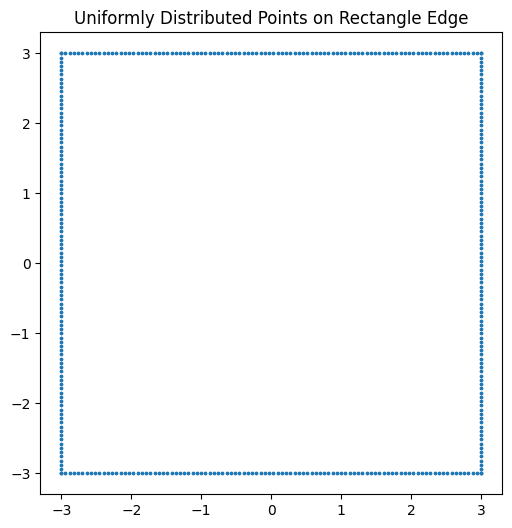

Points shape:  torch.Size([400, 2])


In [234]:
import torch
import matplotlib.pyplot as plt

# Parameters
num_points = 400  # Total number of points
width, height = 1.0, 1.0  # Rectangle dimensions (centered at 0,0)

# Generate points for each edge
num_edge_points = num_points // 4

# Top edge (y = height / 2)
top_edge = torch.stack([
    torch.linspace(-width / 2, width / 2, num_edge_points, device=device),
    torch.full((num_edge_points,), height / 2, device=device)
], dim=1)

# Bottom edge (y = -height / 2)
bottom_edge = torch.stack([
    torch.linspace(-width / 2, width / 2, num_edge_points, device=device),
    torch.full((num_edge_points,), -height / 2, device=device)
], dim=1)

# Right edge (x = width / 2)
right_edge = torch.stack([
    torch.full((num_edge_points,), width / 2, device=device),
    torch.linspace(-height / 2, height / 2, num_edge_points, device=device)
], dim=1)

# Left edge (x = -width / 2)
left_edge = torch.stack([
    torch.full((num_edge_points,), -width / 2, device=device),
    torch.linspace(-height / 2, height / 2, num_edge_points, device=device)
], dim=1)

# Combine all edges
true_points = torch.cat([top_edge, bottom_edge, right_edge, left_edge], dim=0)

# Scale points (if needed)
true_points = true_points * 6.0 

# Plot points
plt.figure(figsize=(6, 6))
plt.axes().set_aspect('equal')
plt.scatter(true_points[:, 0].cpu(), true_points[:, 1].cpu(), s=3)  # Adjust marker size
plt.title("Uniformly Distributed Points on Rectangle Edge")
plt.show()

print("Points shape: ", true_points.shape)



loaded model


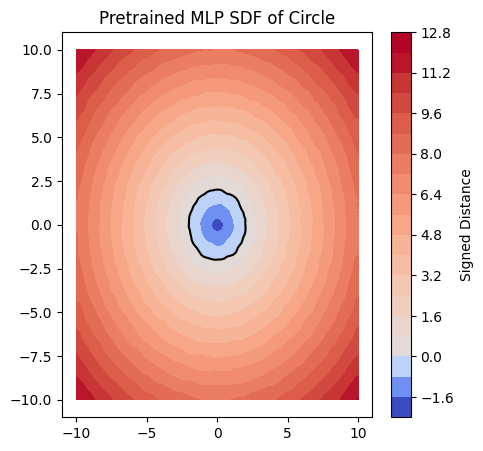

In [235]:
import matplotlib
import os

model = Decoder(multires=multires).to(device)
model_path = 'pretrained_circle.pth'
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print('loaded model')
else:
    print("no model found, pretraining")
    model.pre_train_circle(3000)
    torch.save(model.state_dict(),model_path)

#plot sdf_circle_wave
fig, ax = plt.subplots(figsize=(5, 5))
xx, yy, sdf_values = plot_sdf(ax, model)

#convert sdf to numpy
sdf_values = sdf_values.cpu().detach().numpy()

norm = matplotlib.colors.TwoSlopeNorm(vmin=np.min(sdf_values), vcenter=0, vmax=np.max(sdf_values))

# Plot the SDF with the centered colormap
contour = plt.contourf(xx, yy, sdf_values, levels=20, cmap="coolwarm", norm=norm)

# Add a colorbar with label
plt.colorbar(contour, label="Signed Distance")
plt.title("Pretrained MLP SDF of Circle")
plt.xlim(-11, 11)
plt.ylim(-11, 11)

plt.show()


In [236]:
cvt_loss_values = []
min_distance_loss_values = []
edge_smoothing_loss_values = []
chamfer_distance_loss_values = []
eikonal_loss_values = []
domain_restriction_loss_values = []
zero_true_points_loss_values = []
loss_values = []

def autograd(sites, model, max_iter=100, stop_train_threshold=1e-6, lambda_weights = [0.1,1.0,0.1,0.1,1.0,1.0,0.1]):
    optimizer = torch.optim.Adam([
    {'params': [p for _, p in model.named_parameters()], 'lr': lr_model},
    {'params': [sites], 'lr': lr_sites}
])

    prev_loss = float("inf")
    best_loss = float("inf")
    upsampled = 0.0
    epoch = 0
    lambda_cvt = lambda_weights[0]
    lambda_sdf = lambda_weights[1]
    lambda_min_distance = lambda_weights[2]
    lambda_laplace = lambda_weights[3]
    lamda_chamfer = lambda_weights[4]
    lamda_eikonal = lambda_weights[5]
    lambda_domain_restriction = lambda_weights[6]
    lambda_true_points = lambda_weights[7]
    
    
    
    best_sites = sites.clone()
    best_sites.best_loss = best_loss
    
    gif_frames = []  # List to store individual frames for GIF
    gif_fn = f'{destination}{max_iter}_cvt_{lambda_cvt}_sdf_{lambda_sdf}_min_distance_{lambda_min_distance}_laplace_{lambda_laplace}_chamfer_{lamda_chamfer}.gif'
    fig, ax = plt.subplots(figsize=(5, 5))  # Create a single figure
    last_edges = torch.tensor([])
    last_random_points = torch.tensor([])
    
    while epoch <= max_iter:
        optimizer.zero_grad()
        
        vertices_to_compute = compute_zero_crossing_vertices(sites, model)
        vertices = compute_all_vertices(sites, vertices_to_compute)
        
        # Compute losses       
        cvt_loss = compute_cvt_loss(sites)
        #min_distance_loss = min_distance_regularization_for_op_sites(edges,sites)
        min_distance_loss = sdf_weighted_min_distance_loss(model, sites)
        #edge_smoothing_loss = compute_edge_smoothing_loss(edges, sites, model)
        chamfer_loss = chamfer_distance(true_points, vertices)
        eikonal_loss = eikonal(model)
        domain_restriction_loss = domain_restriction(true_points, model)
        zero_true_points_loss = torch.mean(model(true_points)[:,0]**2)
               
        # Track raw losses (unweighted)
        cvt_loss_values.append(cvt_loss.item())
        min_distance_loss_values.append(min_distance_loss.item())
        #edge_smoothing_loss_values.append(edge_smoothing_loss.item())
        chamfer_distance_loss_values.append(chamfer_loss.item())
        eikonal_loss_values.append(eikonal_loss.item())
        domain_restriction_loss_values.append(domain_restriction_loss.item())
        zero_true_points_loss_values.append(zero_true_points_loss.item())
  
        loss = (
            lambda_cvt * cvt_loss +
            lambda_min_distance * min_distance_loss + 
            #lambda_laplace * edge_smoothing_loss +
            lamda_chamfer * chamfer_loss +
            lamda_eikonal * eikonal_loss +
            lambda_domain_restriction * domain_restriction_loss +
            lambda_true_points * zero_true_points_loss
        )
        loss_values.append(loss.item())
        print(f"Epoch {epoch}: loss = {loss.item()}")
                
        loss.backward()
        optimizer.step()
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = epoch
            best_sites = sites.clone()
            best_sites.best_loss = best_loss
            if upsampled > 0:
                print(f"UPSAMPLED {upsampled} Best Epoch {best_epoch}: Best loss = {best_loss}")
                #return best_sites
        
        if abs(prev_loss - loss.item()) < stop_train_threshold:
            print(f"Converged at epoch {epoch} with loss {loss.item()}")
            #break
        
        prev_loss = loss.item() 
               
        #if epoch>100 and epoch%100 == 1 and upsampled < 2:
        if epoch>100 and (epoch // 100) == upsampled+1 and loss.item() < 0.5 and upsampled < 2:
            print("sites length: ",len(sites))
            new_sites = upsampling_inside(best_sites, model)
            print(new_sites)
            sites = add_upsampled_sites(best_sites, new_sites)
            sites = sites.detach().requires_grad_(True)
            print("upsampled sites length: ",len(sites))
            
            best_sites = sites.clone()
            best_sites.best_loss = best_loss
            
            optimizer = torch.optim.Adam([{'params': [p for _, p in model.named_parameters()], 'lr': lr_model},
                                          {'params': [sites], 'lr': lr_sites}])
            upsampled += 1.0

        # Plot Voronoi diagram
        sites_np = sites.detach().cpu().numpy()
        voronoi_initial = Voronoi(sites_np)
        ax.clear()  # Clear the current plot
        voronoi_plot_2d(voronoi_initial, ax=ax, show_vertices=False, line_colors='blue')
        xx, yy, sdf_values = plot_sdf(ax, model)

        #convert sdf to numpy
        sdf_values = sdf_values.cpu().detach().numpy()

        norm = matplotlib.colors.TwoSlopeNorm(vmin=np.min(sdf_values), vcenter=0, vmax=np.max(sdf_values))

        # Plot the SDF with the centered colormap
        contour = plt.contourf(xx, yy, sdf_values, levels=20, cmap="coolwarm", norm=norm)

        ax.scatter(true_points[:,0].cpu(), true_points[:,1].cpu(), color='green', s=1)

        #plot vertices
        ax.scatter(vertices[:,0].detach().cpu().numpy(), vertices[:,1].detach().cpu().numpy(), color='red', s=30)
        ax.set_title(f"Epoch {epoch} - Loss: {loss:.4f}")
        
        # Save the current figure to an in-memory buffer
        buf = BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        
        # Append the buffer content as an image frame
        gif_frames.append(Image.open(buf))
                        
        if epoch % (max_iter/10) == 0:
            print(f"Epoch {epoch}: loss = {loss.item()}")
            print(f"Best Epoch {best_epoch}: Best loss = {best_loss}")
            # Save the GIF
            gif_frames[0].save(
                f'{destination}{max_iter}_{epoch}_cvt_{lambda_cvt}_sdf_{lambda_sdf}_min_distance_{lambda_min_distance}_laplace_{lambda_laplace}_chamfer_{lamda_chamfer}.gif',
                save_all=True,            
                append_images=gif_frames[1:],
                duration=100,  # Duration in ms between frames
                loop=0
            )
            print("GIF saved as ",f'{destination}{max_iter}_{epoch}_cvt_{lambda_cvt}_sdf_{lambda_sdf}_min_distance_{lambda_min_distance}_laplace_{lambda_laplace}_chamfer_{lamda_chamfer}.gif',
)
                    
        epoch += 1
            
    # Save the GIF
    gif_frames[0].save(
        gif_fn,
        save_all=True,
        append_images=gif_frames[1:],
        duration=100,  # Duration in ms between frames
        loop=0
    )
    print("GIF saved as ", gif_fn)
            
        
    return best_sites

Epoch 0: loss = 12.666663314869204
Epoch 0: loss = 12.666663314869204
Best Epoch 0: Best loss = 12.666663314869204
GIF saved as  ./images/autograd/multiple_sites/500_0_cvt_0.1_sdf_0_min_distance_0.1_laplace_0_chamfer_1.05.gif
Epoch 1: loss = 22.910647934784997
Epoch 2: loss = 8236.016791893238
Epoch 3: loss = 56.37039364123011
Epoch 4: loss = 40.65838851351551
Epoch 5: loss = 20514.437966720747
Epoch 6: loss = 7.772301072997256
Epoch 7: loss = 3.3176382237409383
Epoch 8: loss = 4.951773123562942
Epoch 9: loss = 1.7541369411809038
Epoch 10: loss = 0.9311630631413255
Epoch 11: loss = 0.9985494348967158
Epoch 12: loss = 1.9027907908813437
Epoch 13: loss = 1.4157653110627424
Epoch 14: loss = 1.5789649381465711
Epoch 15: loss = 1.6352892079268126
Epoch 16: loss = 1.5631732709550876
Epoch 17: loss = 1.3790782419197856
Epoch 18: loss = 0.9502206834124112
Epoch 19: loss = 0.6609028271026649
Epoch 20: loss = 0.5434391610299328
Epoch 21: loss = 0.5188715299881541
Epoch 22: loss = 0.7695317542062

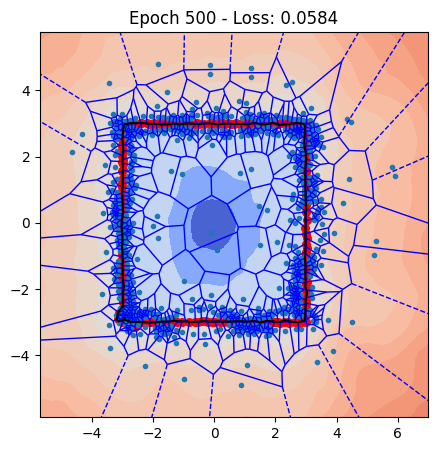

In [237]:
lambda_weights = [0.1,0,0.1,0.001,1.05,0,0,1]

lambda_cvt = lambda_weights[0]
lambda_sdf = lambda_weights[1]
lambda_min_distance = lambda_weights[2]
lambda_laplace = lambda_weights[3]
lamda_chamfer = lambda_weights[4]
lambda_eikonal = lambda_weights[5]
lambda_domain_restriction = lambda_weights[6]
lambda_true_points = lambda_weights[7]

max_iter = 500

site_file_path = f'{destination}{max_iter}_cvt_{lambda_cvt}_sdf_{lambda_sdf}_min_distance_{lambda_min_distance}_laplace_{lambda_laplace}_chamfer_{lamda_chamfer}_eikonal_{lambda_eikonal}.npy'
#check if optimized sites file exists
if os.path.exists(site_file_path):
    #import sites
    print("Importing sites")
    sites = np.load(site_file_path)
    sites = torch.from_numpy(sites).to(device).requires_grad_(True)
    #load model from file
    model = Decoder(multires=multires).to(device)
    model.load_state_dict(torch.load(f'{destination}{max_iter}_cvt_{lambda_cvt}_sdf_{lambda_sdf}_min_distance_{lambda_min_distance}_laplace_{lambda_laplace}_chamfer_{lamda_chamfer}_eikonal_{lambda_eikonal}.pth'))   
    
else:
    sites = autograd(sites, model, max_iter=max_iter, lambda_weights=lambda_weights)
    sites_np = sites.detach().cpu().numpy()
    np.save(site_file_path, sites_np)
    #save model
    torch.save(model.state_dict(), f'{destination}{max_iter}_cvt_{lambda_cvt}_sdf_{lambda_sdf}_min_distance_{lambda_min_distance}_laplace_{lambda_laplace}_chamfer_{lamda_chamfer}_eikonal{lambda_eikonal}.pth')


#print("Sites: ", sites)

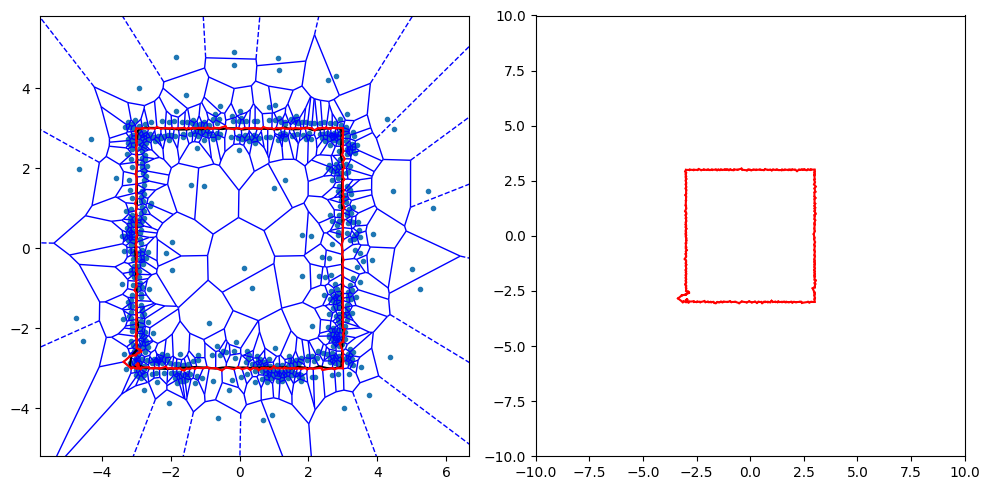

In [238]:
def get_sites_zero_crossing_edges(sites, model):
    sites_np = sites.detach().cpu().numpy()
    # Compute Voronoi diagram
    vor = Voronoi(sites_np)

    # Compute SDF values for each site
    sdf_values = model(sites)[:,0]
    sdf_values = sdf_values.detach().cpu().numpy()

    edges = []
    for (point1, point2), (vertex1, vertex2) in zip(vor.ridge_points, vor.ridge_vertices):
        # Check if vertices are valid (not -1, which indicates infinity)
        if vertex1 == -1 or vertex2 == -1:
            continue
        
        # Check if the sites have different signs
        if np.sign(sdf_values[point1]) != np.sign(sdf_values[point2]):
            edges.append((vertex1, vertex2))
    
    
        # Create two subplots: one with Voronoi diagram and one without
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot with Voronoi diagram
    ax1 = axs[0]
    voronoi_plot_2d(vor, ax=ax1, show_vertices=False, line_colors='blue')
    plot_sdf(ax1, model)

    #ax1.set_title("With Voronoi Diagram")

    # Plot edges
    for vertex1, vertex2 in edges:
        v1 = vor.vertices[vertex1]
        v2 = vor.vertices[vertex2]
        ax1.plot([v1[0], v2[0]], [v1[1], v2[1]], 'r-')

    #ax1.legend(['Zero-crossing edges'], loc='upper right')

    # Plot without Voronoi diagram
    ax2 = axs[1]
    #plot_sdf(ax2, model)

    #ax2.set_title("Without Voronoi Diagram")
    #plt.triplot(*zip(*sites_np), 'o', markersize=3, color='blue')

    # Plot edges
    for vertex1, vertex2 in edges:
        v1 = vor.vertices[vertex1]
        v2 = vor.vertices[vertex2]
        ax2.plot([v1[0], v2[0]], [v1[1], v2[1]], 'r-')

    #ax2.legend(['Zero-crossing edges'], loc='upper right')
    # plt.plot([], [], 'r-', label='sites zero-crossing edge')
    # limit of the plot
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.tight_layout()
    plt.savefig(f'{destination}edge_sdf_crossing.png')
    
    plt.show()            
            
    return edges


edges = get_sites_zero_crossing_edges(sites, model)



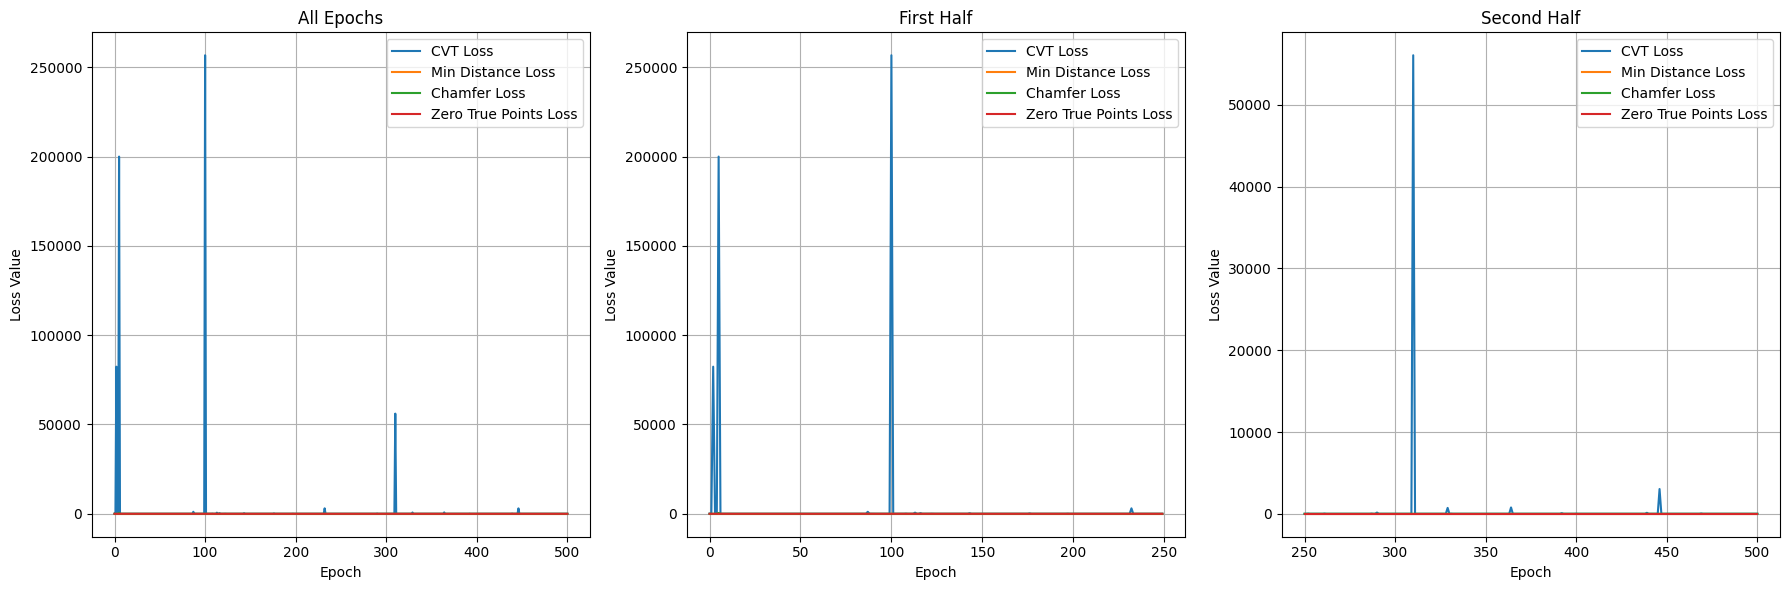

In [243]:
# Define the total number of epochs and split into halves
total_epochs = len(chamfer_distance_loss_values)
half_epoch = total_epochs // 2

# Create a figure with 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot all epochs (x-axis from 0 to 80)
#axes[0].plot(range(total_epochs), sdf_loss_values, label="SDF Loss")
axes[0].plot(range(total_epochs), cvt_loss_values, label="CVT Loss")
axes[0].plot(range(total_epochs), min_distance_loss_values, label="Min Distance Loss")
#axes[0].plot(range(total_epochs), edge_smoothing_loss_values, label="Edge Smoothing Loss")
axes[0].plot(range(total_epochs), chamfer_distance_loss_values, label="Chamfer Loss")
#axes[0].plot(range(total_epochs), eikonal_loss_values, label="Eikonal Loss")
#axes[0].plot(range(total_epochs), domain_restriction_loss_values, label="Domain Restriction Loss")
axes[0].plot(range(total_epochs), zero_true_points_loss_values, label="Zero True Points Loss")

#axes[0].set_xlim(0, 80)  # Set x-axis range from 0 to 80
axes[0].set_title("All Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss Value")
axes[0].legend()
axes[0].grid(True)


# Plot first half 
#axes[1].plot(range(half_epoch), sdf_loss_values[:half_epoch], label="SDF Loss")
axes[1].plot(range(half_epoch), cvt_loss_values[:half_epoch], label="CVT Loss")
axes[1].plot(range(half_epoch), min_distance_loss_values[:half_epoch], label="Min Distance Loss")
#axes[1].plot(range(half_epoch), edge_smoothing_loss_values[:half_epoch], label="Edge Smoothing Loss")
axes[1].plot(range(half_epoch), chamfer_distance_loss_values[:half_epoch], label="Chamfer Loss")
#axes[1].plot(range(half_epoch), eikonal_loss_values[:half_epoch], label="Eikonal Loss")
#axes[1].plot(range(half_epoch), domain_restriction_loss_values[:half_epoch], label="Domain Restriction Loss")
axes[1].plot(range(half_epoch), zero_true_points_loss_values[:half_epoch], label="Zero True Points Loss")

axes[1].set_title("First Half")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss Value")
axes[1].legend()
axes[1].grid(True)

# Plot second half 
#axes[2].plot(range(half_epoch, total_epochs), sdf_loss_values[half_epoch:], label="SDF Loss")
axes[2].plot(range(half_epoch, total_epochs), cvt_loss_values[half_epoch:], label="CVT Loss")
axes[2].plot(range(half_epoch, total_epochs), min_distance_loss_values[half_epoch:], label="Min Distance Loss")
#axes[2].plot(range(half_epoch, total_epochs), edge_smoothing_loss_values[half_epoch:], label="Edge Smoothing Loss")
axes[2].plot(range(half_epoch, total_epochs), chamfer_distance_loss_values[half_epoch:], label="Chamfer Loss")
#axes[2].plot(range(half_epoch, total_epochs), eikonal_loss_values[half_epoch:], label="Eikonal Loss")
#axes[2].plot(range(half_epoch, total_epochs), domain_restriction_loss_values[half_epoch:], label="Domain Restriction Loss")
axes[2].plot(range(half_epoch, total_epochs), zero_true_points_loss_values[half_epoch:], label="Zero True Points Loss")

axes[2].set_title("Second Half")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Loss Value")
axes[2].legend()
axes[2].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


ValueError: x and y must have same first dimension, but have shapes (501,) and (0,)

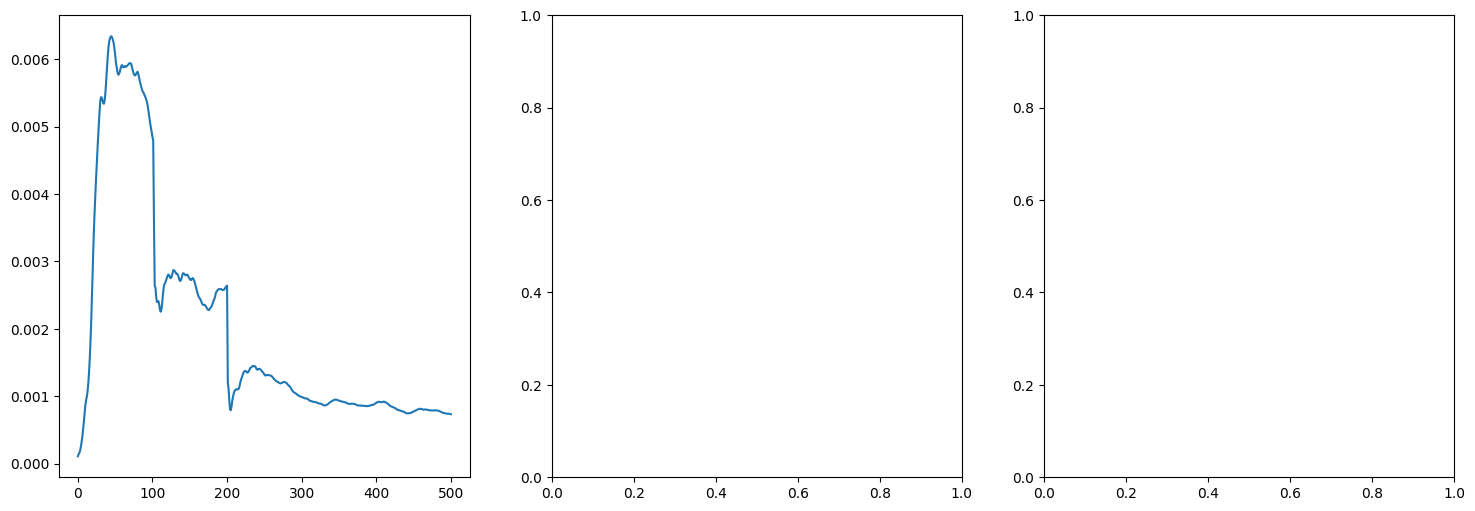

In [256]:
lambda_cvt = lambda_weights[0]
lambda_sdf = lambda_weights[1]
lambda_min_distance = lambda_weights[2]
lambda_laplace = lambda_weights[3]
lambda_chamfer = lambda_weights[4]
lambda_eikonal = lambda_weights[5]
lambda_domain_restriction = lambda_weights[6]
    
# Define the total number of epochs and split into halves
total_epochs = len(chamfer_distance_loss_values)
half_epoch = total_epochs // 2

# Create a figure with 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot all epochs (x-axis from 0 to 80)
#axes[0].plot(range(total_epochs), [x*lambda_sdf for x in sdf_loss_values], label="SDF Loss")
#axes[0].plot(range(total_epochs), [x*lambda_cvt for x in cvt_loss_values], label="CVT Loss")
axes[0].plot(range(total_epochs), [x*lambda_min_distance for x in min_distance_loss_values], label="Min Distance Loss")
#axes[0].plot(range(total_epochs), [x*lambda_laplace for x in edge_smoothing_loss_values], label="Edge Smoothing Loss")
axes[0].plot(range(total_epochs), [x*lambda_chamfer for x in chamfer_distance_loss_values], label="Chamfer Loss")
#axes[0].plot(range(total_epochs), [x*lambda_eikonal for x in eikonal_loss_values], label="Eikonal Loss")
#axes[0].plot(range(total_epochs), [x*lambda_domain_restriction for x in domain_restriction_loss_values], label="Domain Restriction Loss")
axes[0].plot(range(total_epochs), [x*lambda_true_points for x in zero_true_points_loss_values], label="Zero True Points Loss")

#axes[0].set_xlim(0, 80)  # Set x-axis range from 0 to 80
axes[0].set_ylim(0, 5)

axes[0].set_title("All Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss Value")
axes[0].legend()
axes[0].grid(True)


# Plot first half 
#axes[1].plot(range(half_epoch), [x*lambda_sdf for x in sdf_loss_values[:half_epoch]], label="SDF Loss")
#axes[1].plot(range(half_epoch), [x*lambda_cvt for x in cvt_loss_values[:half_epoch]], label="CVT Loss")
axes[1].plot(range(half_epoch), [x*lambda_min_distance for x in min_distance_loss_values[:half_epoch]], label="Min Distance Loss")
#axes[1].plot(range(half_epoch), [x*lambda_laplace for x in edge_smoothing_loss_values[:half_epoch]], label="Edge Smoothing Loss")
axes[1].plot(range(half_epoch), [x*lambda_chamfer for x in chamfer_distance_loss_values[:half_epoch]], label="Chamfer Loss")
#axes[1].plot(range(half_epoch), [x*lambda_eikonal for x in eikonal_loss_values[:half_epoch]], label="Eikonal Loss")
#axes[1].plot(range(half_epoch), [x*lambda_domain_restriction for x in domain_restriction_loss_values[:half_epoch]], label="Domain Restriction Loss")
axes[1].plot(range(half_epoch), [x*lambda_true_points for x in zero_true_points_loss_values[:half_epoch]], label="Zero True Points Loss")

axes[1].set_title("First Half")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss Value")
axes[1].legend()
axes[1].grid(True)

# Plot second half 
#axes[2].plot(range(half_epoch, total_epochs), [x*lambda_sdf for x in sdf_loss_values[half_epoch:]], label="SDF Loss")
#axes[2].plot(range(half_epoch, total_epochs), [x*lambda_cvt for x in cvt_loss_values[half_epoch:]], label="CVT Loss")
axes[2].plot(range(half_epoch, total_epochs), [x*lambda_min_distance for x in min_distance_loss_values[half_epoch:]], label="Min Distance Loss")
#axes[2].plot(range(half_epoch, total_epochs), [x*lambda_laplace for x in edge_smoothing_loss_values[half_epoch:]], label="Edge Smoothing Loss")
axes[2].plot(range(half_epoch, total_epochs), [x*lambda_chamfer for x in chamfer_distance_loss_values[half_epoch:]], label="Chamfer Loss")
#axes[2].plot(range(half_epoch, total_epochs), [x*lambda_eikonal for x in eikonal_loss_values[half_epoch:]], label="Eikonal Loss")
#axes[2].plot(range(half_epoch, total_epochs), [x*lambda_domain_restriction for x in domain_restriction_loss_values[half_epoch:]], label="Domain Restriction Loss")
axes[2].plot(range(half_epoch, total_epochs), [x*lambda_true_points for x in zero_true_points_loss_values[half_epoch:]], label="Zero True Points Loss")

axes[2].set_title("Second Half")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Loss Value")
axes[2].legend()
axes[2].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
#retrain limit

# Show the plots
plt.show()


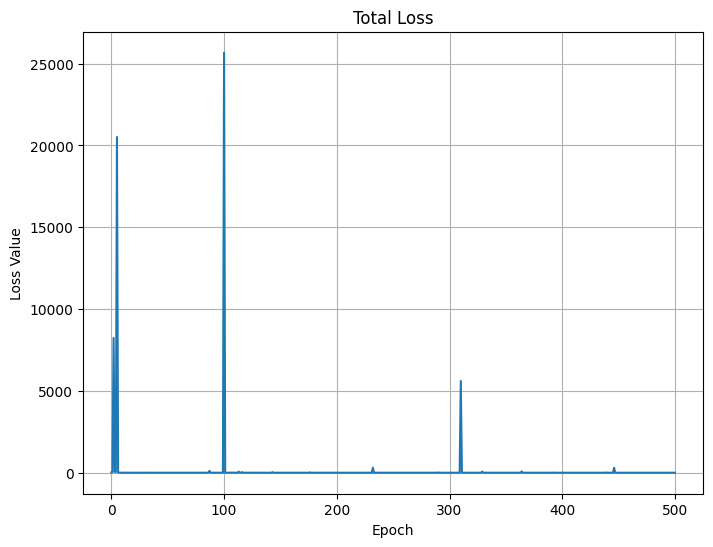

In [241]:
# Plot the final loss
plt.figure(figsize=(8, 6))
plt.plot(range(len(loss_values)), loss_values)
plt.title("Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.grid(True)
plt.show()
